# Term Document Matrices, Summarization

In [1]:
%%capture
!pip install ipypublish
!pip install transformers

In [2]:
%pylab inline
import pandas as pd
import os
from ipypublish import nb_setup
%load_ext rpy2.ipython

Populating the interactive namespace from numpy and matplotlib


In [3]:
from google.colab import drive
drive.mount('/content/drive')  # Add My Drive/<>

import os
os.chdir('drive/My Drive')
os.chdir('Teaching/NLP')

Mounted at /content/drive


## Getting SEC Data and Special Dictionaries

In [4]:
%%capture
!pip install  wordcloud
!pip install multidict
!pip install qgrid

In [69]:
#Negative words
df = pd.read_excel('NLP_data/LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Negative', header=None)
df.columns = ["Neg"]
LM_neg = df.Neg.str.lower().to_list()
#Positive words
df = pd.read_excel('NLP_data/LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Positive', header=None)
df.columns = ["Pos"]
LM_pos = df.Pos.str.lower().to_list()
#Uncertainty words
df = pd.read_excel('NLP_data/LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Uncertainty', header=None)
df.columns = ["Unc"]
LM_unc = df.Unc.str.lower().to_list()
#Litigious words
df = pd.read_excel('NLP_data/LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Litigious', header=None)
df.columns = ["Lit"]
LM_lit = df.Lit.str.lower().to_list()

In [6]:
def finScore(url,poswords,negwords,uncwords,litwords):
    f = requests.get(url)
    text = f.text
    f.close()
    text = BeautifulSoup(text,'html').get_text()    
    text = text.replace('\n',' ').lower()
    text = text.split(' ')
    posmatches = set(text).intersection(set(poswords))
    print(posmatches)
    print(len(posmatches))
    negmatches = set(text).intersection(set(negwords))
    print(negmatches)
    print(len(negmatches))
    uncmatches = set(text).intersection(set(uncwords))
    print(uncmatches)
    print(len(uncmatches))
    litmatches = set(text).intersection(set(litwords))
    print(litmatches)
    print(len(litmatches))
    return posmatches, negmatches, uncmatches, litmatches, text

In [7]:
from wordcloud import WordCloud
import multidict as multidict

import os
import re
from PIL import Image
from os import path

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict


def makeImage(text):
    wc = WordCloud(background_color="white", max_words=1000, max_font_size=40, mask=mask)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    imshow(wc, interpolation="bilinear")
    axis("off")
    show()


# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

In [15]:
#Function to convert ticker into CIK
import re
import requests
from requests import get

def ticker2cik(ticker):
    DEFAULT_TICKERS = ['goog', 'aapl']
    URL = 'http://www.sec.gov/cgi-bin/browse-edgar?CIK={}&Find=Search&owner=exclude&action=getcompany'
    CIK_RE = re.compile(r'.*CIK=(\d{10}).*')
    x = get(URL.format(ticker)).content
    return CIK_RE.findall(str(x))[0]

In [70]:
url = 'https://www.sec.gov/Archives/edgar/cik-lookup-data.txt'

f = requests.get(url)
cik = f.text
cik = cik.splitlines()
f.close()
print('No of companies: ',len(cik))

No of companies:  801222


In [73]:
y = array([[j[:-12],j[-11:-1]] for j in cik]).T
df = pd.DataFrame({'Company_Name': y[0], 'CIK':y[1]})
df

,Company_Name,CIK
0,!J INC,0001438823
1,"#1 A LIFESAFER HOLDINGS, INC.",0001509607
2,#1 ARIZONA DISCOUNT PROPERTIES LLC,0001457512
3,#1 PAINTBALL CORP,0001433777
4,$ LLC,0001427189
...,...,...
801217,ZZIF 2008 INVESTMENT LLC,0001448632
801218,"ZZLL INFORMATION TECHNOLOGY, INC",0001365357
801219,"ZZX, LLC",0001691924
801220,ZZYZX ZZAZX ZZOZX INC,0001184274


In [11]:
# import ipywidgets
# import qgrid
# qgrid_widget = qgrid.show_grid(df, show_toolbar=True)
# qgrid_widget

In [74]:
%load_ext google.colab.data_table
from google.colab import data_table
data_table.DataTable(df, include_index=False, num_rows_per_page=20)
# %unload_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


,Company_Name,CIK
0,!J INC,0001438823
1,"#1 A LIFESAFER HOLDINGS, INC.",0001509607
2,#1 ARIZONA DISCOUNT PROPERTIES LLC,0001457512
3,#1 PAINTBALL CORP,0001433777
4,$ LLC,0001427189
...,...,...
801217,ZZIF 2008 INVESTMENT LLC,0001448632
801218,"ZZLL INFORMATION TECHNOLOGY, INC",0001365357
801219,"ZZX, LLC",0001691924
801220,ZZYZX ZZAZX ZZOZX INC,0001184274


## Get the 10K and score it

In [79]:
ticker = 'AAPL'
cik_number = ticker2cik(ticker) # AAPL:0000320193; AMZN:0001018724; MSFT:0000789019; C1: 0001003952
print('Ticker: ',ticker,' CIK: ',cik_number)

Ticker:  AAPL  CIK:  0000320193


In [80]:
# Get 10K
# https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=320193 (page with all forms)
# cik_number = '0001512733'
cik_no_zeros = cik_number.lstrip('0')
url = ['https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK='+cik_no_zeros+'&type=&dateb=&owner=include&start=0&count=100',
       'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK='+cik_no_zeros+'&type=&dateb=&owner=include&start=100&count=200',
       'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK='+cik_no_zeros+'&type=&dateb=&owner=include&start=200&count=300',
       'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK='+cik_no_zeros+'&type=&dateb=&owner=include&start=300&count=400',
       'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK='+cik_no_zeros+'&type=&dateb=&owner=include&start=400&count=500']

idx = 0
for u in url:
    f = requests.get(u)
    txt = f.text
    f.close()
    idx = txt.find("10-K")
    if idx>0:
        x = txt[idx:(idx+300)]
        x1 = x.find('href')
        x2 = x.find('index.htm')
        url = 'https://www.sec.gov' + x[(x1+6):(x2-1)] + '.txt'
        break

if idx>0:
    print(url)
else:
    print('No 10-K found')

https://www.sec.gov/Archives/edgar/data/320193/000032019320000096/0000320193-20-000096.txt


In [81]:
!pip install bs4
from bs4 import BeautifulSoup

#Unique sets of words in the 10-K
poswords = LM_pos
negwords = LM_neg
uncwords = LM_unc
litwords = LM_lit
pos, neg, unc, lit, text = finScore(url,poswords,negwords,uncwords,litwords)

{'able', 'good', 'successfully', 'achieving', 'benefit', 'adequately', 'innovative', 'advancements', 'conclusive', 'satisfaction', 'strong', 'assuring', 'beneficial', 'greater', 'favorable', 'effective', 'opportunities', 'profitability', 'rewards', 'integrity', 'highest', 'achieve', 'improve', 'improvements', 'attractive', 'improved', 'improving', 'resolve', 'accomplish', 'gains', 'success', 'satisfactory', 'gain', 'better', 'exclusive', 'innovations', 'strength', 'successful', 'satisfying', 'advantage', 'transparency', 'strengthening', 'satisfy', 'desirable', 'improvement', 'best', 'enhance', 'gained', 'collaborate', 'satisfied'}
50
{'obsolescence', 'hostile', 'lacks', 'distracting', 'unwilling', 'disclosed', 'risky', 'critical', 'unpredictable', 'obsolete', 'interfering', 'disruptions', 'alleging', 'default', 'abrupt', 'inefficiencies', 'breached', 'failure', 'volatile', 'perpetrated', 'errors', 'prevention', 'closures', 'violations', 'conflict', 'adversely', 'terminated', 'closed', 

In [82]:
pos = [j for j in text if j in poswords]  
print('Number of positives: ',len(pos))
neg = [j for j in text if j in negwords]
print('Number of negatives: ',len(neg))
unc = [j for j in text if j in uncwords]
print('Number of uncertains: ',len(unc))
lit = [j for j in text if j in litwords]
print('Number of litigious: ',len(lit))

Number of positives:  710
Number of negatives:  1398
Number of uncertains:  1186
Number of litigious:  2056


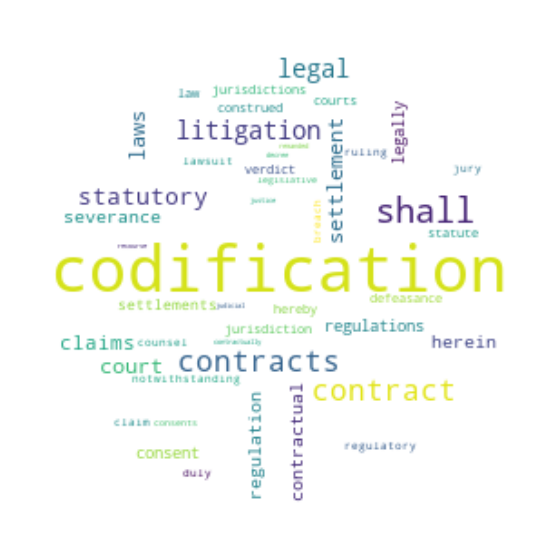

In [83]:
figure(figsize=(10,10))
litigious = " ".join(list(lit))
makeImage(getFrequencyDictForText(litigious))

## Term Document Matrix

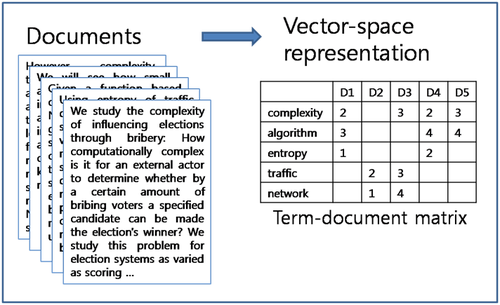

In [30]:
nb_setup.images_hconcat(["NLP_images/tdm.png"], width=500)

## Term Frequency - Inverse Document Frequency (TF-IDF)

This is a weighting scheme provided to sharpen the importance of rare words in a document, relative to the frequency of these words in the corpus. It is based on simple calculations and even though it does not have strong theoretical foundations, it is still very useful in practice. The TF-IDF is the importance of a word $w$ in a document $d$ in a corpus $C$. Therefore it is a function of all these three, i.e., we write it as $TFIDF(w,d,C)$, and is the product of term frequency (TF) and inverse document frequency (IDF).

The frequency of a word in a document is defined as

$$
f(w,d)=\frac{\#w \in d}{|d|}
$$

where $|d|$ is the number of words in the document. We may normalize word frequency so that

$$
TF(w,d)=ln[f(w,d)]
$$

This is log normalization. Another form of normalization is known as double normalization and is as follows:

$$
TF(w,d)=\frac{1}{2} + \frac{1}{2} \cdot \frac{f(w,d)}{\max_{w \in d} f(w,d)}
$$

Note that normalization is not necessary, but it tends to help shrink the difference between counts of words.

Inverse document frequency is as follows (in this case we show the normalized version):

$$
IDF(w,C)=\ln\left[\frac{|C|}{|d_{w \in d}|}\right]
$$

That is, we compute the ratio of the number of documents in the corpus $C$ divided by the number of documents with word $w$ in the corpus.

Finally, we have the weighting score for a given word $w$ in document $d$ in corpus $C$:

$$
TFIDF(w,d,C)=TF(w,d) \times IDF(w,C)
$$

In [84]:
# Collect some text data
!pip install cssselect
import requests
from lxml.html import fromstring

#Copy the URL from the web site
url = 'https://economictimes.indiatimes.com'
html = requests.get(url, timeout=10).text

#See: http://infohost.nmt.edu/~shipman/soft/pylxml/web/etree-fromstring.html
doc = fromstring(html)      

#http://lxml.de/cssselect.html#the-cssselect-method
doc.cssselect(".active")

x = doc.cssselect(".active li")    #Try a, h2, section if you like
headlines = [x[j].text_content() for j in range(len(x))]
headlines = headlines[:20]   #Needed to exclude any other stuff that was not needed. 
print(headlines)

['Great Wall looks to reboot India entry plans', 'NHAI extends bidding deadlines for projects', 'MNCs ramp-up efforts to help staff in India', 'RBI launches surveys to gauge expectations', "Tata Communications disputes DoT's demand", 'CSK marches on with another win over SRH', 'Apollo 11 astronaut Michael Collins dies at 90', 'Tata Steel ramps up oxygen production', 'TV Somanathan designated Finance Secretary', 'Cost to cover default risks goes up for banks', "You can soon spot cars with 'IN' registration", "Poonawalla to get 'Y' category security ", "'UK jobs at risk amid confectionery revamp'", 'Zoom Studios Flick sees unprecedented growth', 'Vax drive may not hit state finances much', 'Second wave will dampen recovery: Report', '', 'COVID-relief material import norms relaxed', 'Boeing posts USD 537 million loss in Q1', 'ONGC wants foreign partners in new fields']


In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(headlines)
tfs = tfidf.fit_transform(headlines)
tfs

<20x117 sparse matrix of type '<class 'numpy.float64'>'
	with 131 stored elements in Compressed Sparse Row format>

In [86]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
res = [word_tokenize(j) for j in headlines]
res[:2]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[['Great', 'Wall', 'looks', 'to', 'reboot', 'India', 'entry', 'plans'],
 ['NHAI', 'extends', 'bidding', 'deadlines', 'for', 'projects']]

In [87]:
# Make TDM
tdm_mat = tfs.toarray().T
print(tdm_mat.shape)
tdm_mat

(117, 20)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.36447019,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## WordClouds

In [35]:
text = ''
for h in headlines:
    text = text + ' ' + h
print(text)

 Great Wall looks to reboot India entry plans NHAI extends bidding deadlines for projects MNCs ramp-up efforts to help staff in India RBI launches surveys to gauge expectations Tata Communications disputes DoT's demand CSK marches on with another win over SRH Apollo 11 astronaut Michael Collins dies at 90 Tata Steel ramps up oxygen production TV Somanathan designated Finance Secretary Cost to cover default risks goes up for banks You can soon spot cars with 'IN' registration Poonawalla to get 'Y' category security  'UK jobs at risk amid confectionery revamp' Zoom Studios Flick sees unprecedented growth Vax drive may not hit state finances much Second wave will dampen recovery: Report  COVID-relief material import norms relaxed Boeing posts USD 537 million loss in Q1 ONGC wants foreign partners in new fields


(-0.5, 399.5, 199.5, -0.5)

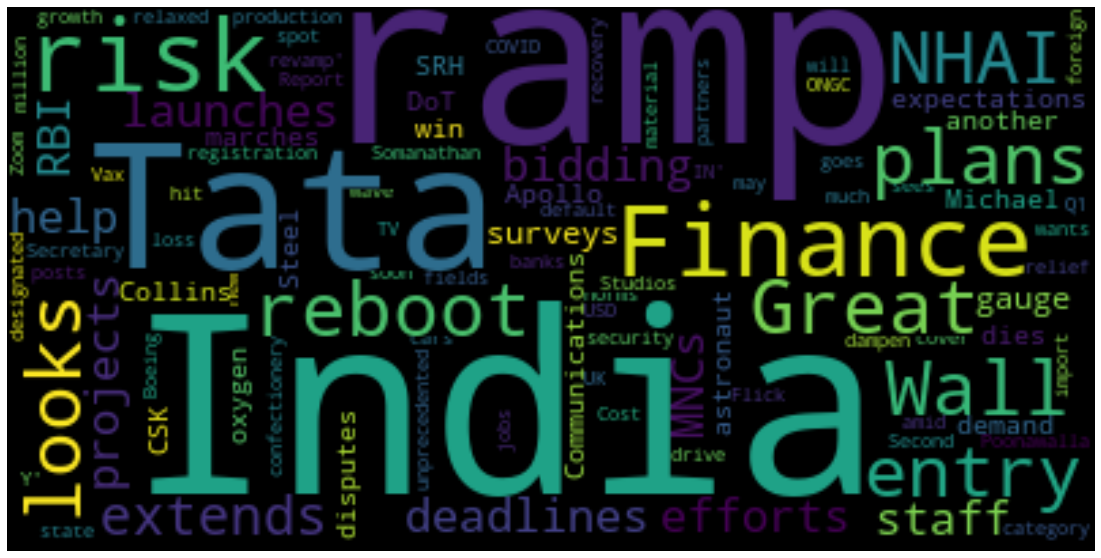

In [36]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(text)

#Use pyplot from matplotlib
figure(figsize=(20,10))
pyplot.imshow(wordcloud, interpolation='bilinear')
pyplot.axis("off")

## Cosine Similarity in the Text Domain

In this segment we will learn some popular functions on text that are used in practice. One of the first things we like to do is to find similar text or like sentences (think of web search as one application). Since documents are vectors in the TDM, we may want to find the closest vectors or compute the distance between vectors.

$$
\cos(\theta) = \frac{A \cdot B}{||A|| \cdot ||B||}
$$
 

where $||A|| = \sqrt{A \cdot A}$, is the dot product of $A$ with itself, also known as the norm of $A$. This gives the cosine of the angle between the two vectors and is zero for orthogonal vectors and 1 for identical vectors.

For a collection of distance measures, see: https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa 

In [88]:
#COSINE DISTANCE OR SIMILARITY
A = array([0,3,4,1,7,0,1])
B = array([0,4,3,0,6,1,1])
cos = A.dot(B)/(sqrt(A.dot(A)) * sqrt(B.dot(B)))
print('Cosine similarity = ',cos)

#Using sklearn
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([A, B], dense_output=True)

Cosine similarity =  0.9682727993019339


array([[1.       , 0.9682728],
       [0.9682728, 1.       ]])

## Minimum Edit Distance

The MED is the minimum number of edits needed to transform one string into another. The strings could be words or sentences or even documents. This is also known as the Levenshtein distance. 

For example, to convert Apple into Amazon, we need to change p->m, p->a, l->z, e->o, add n. This entails 5 simple operations. 

**Properties**:

1. Zero only for identical strings. 
2. Minimum = the difference of the sizes of the two strings.
3. Maximum = length of the longer string.
4. Satisfies the Triangle Inequality: The Levenshtein distance between two strings is no greater than the sum of their Levenshtein distances from a third string.


See the Lazy Prices paper: https://hbswk.hbs.edu/item/lazy-prices, which uses MED for document similarity. Get the published paper through the library for free: https://onlinelibrary.wiley.com/doi/epdf/10.1111/jofi.12885

(Adapted from https://github.com/kristinauko/challenge_100/blob/master/day28.py)

In [89]:
def min_edit_distance(string1, string2):

    if len(string1) > len(string2):
        difference = len(string1) - len(string2)
        string1[:difference]

    elif len(string2) > len(string1):
        difference = len(string2) - len(string1)
        string2[:difference]

    else:
        difference = 0

    for i in range(min(len(string1),len(string2))):
        if string1[i] != string2[i]:
            difference += 1

    return difference

print(min_edit_distance("Amazon", "Apple")) 
print(min_edit_distance("Amazon", "Amazing")) 

5
2


## Simple Similarity 

(Also in the Lazy Prices paper.)

This measure compares two documents word by word or character by character. It uses an old document $D_1$ and a new document $D_2$ and counts the additions, deletions, and changes of words, normalized by the sum of words in the two documents. 

It is a simple side-by-side comparison method. Much like the function “Track Changes” in Microsoft Word or the function “diff” in Unix/Linux terminal.

First we look at MED at the word level and then consider Simple Similarity.

In [90]:
import os
import difflib  # https://docs.python.org/2/library/difflib.html
from nltk.tokenize import word_tokenize

D1 = "Some areas around the world that were devastated by the coronavirus in the spring — and are now tightening rules to head off a second wave — are facing resistance from residents who are exhausted, confused and frustrated."
print(D1, "\n")
D1 = word_tokenize(D1)

D2 = "Some parts of the world devastated by the terrible coronavirus in the winter — have now tightened rules to head off a second wave but are facing resistance from residents who are exhausted, bewildered and angry."
print(D2, "\n")
D2 = word_tokenize(D2)

print("Length D1: ",len(D1[:5]),D1[:5])
print("Length D2: ",len(D2[:5]),D2[:5])
print("MED =",min_edit_distance(D1[:5],D2[:5])) 

print("Length D1: ",len(D1),D1)
print("Length D2: ",len(D2),D2)
print("MED =",min_edit_distance(D1,D2)) 

Some areas around the world that were devastated by the coronavirus in the spring — and are now tightening rules to head off a second wave — are facing resistance from residents who are exhausted, confused and frustrated. 

Some parts of the world devastated by the terrible coronavirus in the winter — have now tightened rules to head off a second wave but are facing resistance from residents who are exhausted, bewildered and angry. 

Length D1:  5 ['Some', 'areas', 'around', 'the', 'world']
Length D2:  5 ['Some', 'parts', 'of', 'the', 'world']
MED = 2
Length D1:  40 ['Some', 'areas', 'around', 'the', 'world', 'that', 'were', 'devastated', 'by', 'the', 'coronavirus', 'in', 'the', 'spring', '—', 'and', 'are', 'now', 'tightening', 'rules', 'to', 'head', 'off', 'a', 'second', 'wave', '—', 'are', 'facing', 'resistance', 'from', 'residents', 'who', 'are', 'exhausted', ',', 'confused', 'and', 'frustrated', '.']
Length D2:  38 ['Some', 'parts', 'of', 'the', 'world', 'devastated', 'by', 'the', 

In [40]:
res = list(difflib.ndiff(D1,D2))
print("DIFFs =",res)
nplus = len([j for j in res if j[0].startswith('+')])
nminus = len([j for j in res if j[0].startswith('-')])
print("SIMPSIM =",nplus,nminus,(nplus+nminus)/(len(D1)+len(D2)))

DIFFs = ['  Some', '- areas', '- around', '+ parts', '+ of', '  the', '  world', '- that', '- were', '  devastated', '  by', '  the', '+ terrible', '  coronavirus', '  in', '  the', '- spring', '+ winter', '  —', '+ have', '- and', '- are', '  now', '- tightening', '+ tightened', '  rules', '  to', '  head', '  off', '  a', '  second', '  wave', '- —', '+ but', '  are', '  facing', '  resistance', '  from', '  residents', '  who', '  are', '  exhausted', '  ,', '- confused', '+ bewildered', '  and', '- frustrated', '+ angry', '  .']
SIMPSIM = 9 11 0.2564102564102564


## Sentence Similarity via Language Representation

We can determine sentence similarity based on raw text using set-based similarity methods, as we will see later in this notebook. 

However, computing similarity is basically a mathematical operation and requires quantification of text into vectors, matrices, tensors. We have seen an example of such similarity in the computation of cosine similarity above. In that example, we used simple word count vectors. 

However, there are other ways of transforming sentences into fixed-length vectors so that we can compute cosine similarity. These are known as "embeddings", i.e., we convert the text of a sentence into a numeric vector of dimension $n$ which can be thought of as an embedding of that sentence into $n$-dimensional space. 

Two popular ways this is done is using traditional word embeddings such as word2vec and BERT model embeddings. Word2vec creates word embeddings and there is a corresponding package for sentence enbeddings, sent2vec. 

In [41]:
!pip install sent2vec

In [91]:
from scipy import spatial # for cosine distance
from sent2vec.vectorizer import Vectorizer # uses DistilBERT

sentences = [
    "There are several approaches to learn NLP.",
    "BERT is an amazing NLP language model.",
    "We can use embedding, encoding, or vectorizing to represent language.",
]

vectorizer = Vectorizer()
vectorizer.bert(sentences)
vectors_bert = vectorizer.vectors

print(len(vectors_bert))
print([len(v) for v in vectors_bert])
print(vectors_bert[0])

3
[768, 768, 768]
[-2.26823196e-01 -1.47761256e-01 -5.47605101e-03 -3.04903418e-01
 -3.22079271e-01 -1.62703648e-01  2.03434061e-02  1.00655489e-01
  3.73835005e-02 -5.03204167e-01 -1.22439981e-01  1.63336307e-01
  1.29844947e-02  6.99331611e-02  3.26597206e-02  3.87873709e-01
 -7.58986280e-04  2.40361542e-01 -1.91939786e-01 -2.15191036e-01
 -1.55010998e-01 -5.68636060e-02  1.55610532e-01 -8.65277424e-02
  8.88795592e-04 -6.96207434e-02  7.45739937e-02  9.62959230e-02
  2.06479236e-01 -6.76915720e-02 -9.84045640e-02  4.25804943e-01
 -1.33869752e-01 -2.16157645e-01  1.26786411e-01  6.81596994e-02
  3.96859705e-01  1.13229886e-01  4.18778449e-01  3.79231200e-02
 -1.06499612e-01  9.64723378e-02  1.49632886e-01  9.64186564e-02
 -4.75685075e-02 -1.01827681e-01 -2.63574910e+00  1.65034048e-02
 -4.71193790e-01 -4.67932373e-01 -1.86668605e-01  2.94501930e-01
  9.48903635e-02  5.40360451e-01  8.56128708e-03  3.07039261e-01
 -3.35935920e-01  1.45308629e-01  1.37860432e-01  2.19708189e-01
  9.555

In [43]:
print(sentences)
dist_1 = 1 - spatial.distance.cosine(vectors_bert[0], vectors_bert[1]) # Similarity = 1 - Distance
print(dist_1)
dist_2 = 1 - spatial.distance.cosine(vectors_bert[0], vectors_bert[2])
print(dist_2)
dist_3 = 1 - spatial.distance.cosine(vectors_bert[1], vectors_bert[2])
print(dist_3)

['There are several approaches to learn NLP.', 'BERT is an amazing NLP language model.', 'We can use embedding, encoding, or vectorizing to represent language.']
0.9422925114631653
0.8620277643203735
0.8503697514533997


To summarize, here is a graphic that depicts various distance measures. 

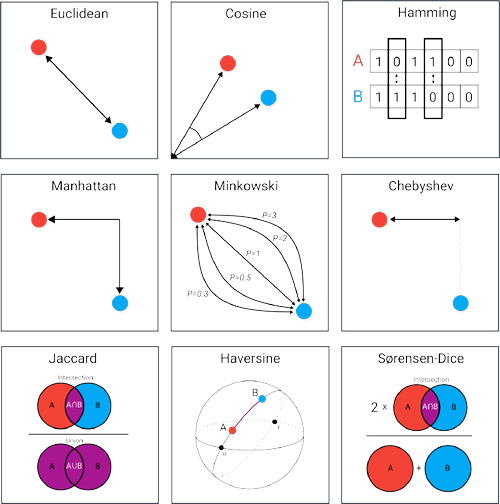

In [44]:
nb_setup.images_hconcat(["NLP_images/Distance_Measures_in_DataScience.png"], width=500)

## Readability of Text 

Or, how to grade text!

In recent years, the SAT exams added a new essay section. While the test aimed at assessing original writing, it also introduced automated grading. A goal of the test is to assess the writing level of the student. This is associated with the notion of readability.

“Readability” is a metric of how easy it is to comprehend text. Given a goal of efficient markets, regulators want to foster transparency by making sure financial documents that are disseminated to the investing public are readable. Hence, metrics for readability are very important and are recently gaining traction.

## Gunning-Fog Index

Gunning (1952) developed the Fog index. The index estimates the years of formal education needed to understand text on a first reading. A fog index of 12 requires the reading level of a U.S. high school senior (around 18 years old). The index is based on the idea that poor readability is associated with longer sentences and complex words. Complex words are those that have more than two syllables. The formula for the Fog index is

$$
0.4 \left[\frac{\#words}{\#sentences} + 100 \cdot \frac{\#complex words}{\#words} \right]
$$
 

## Flesch Score

Alternative readability scores use similar ideas. The Flesch Reading Ease Score and the Flesch-Kincaid Grade Level also use counts of words, syllables, and sentences. See http://en.wikipedia.org/wiki/Flesch-Kincaid_readability_tests. The Flesch Reading Ease Score is defined as

$$
206.835−1.015 \cdot \frac{\#words}{\#sentences} − 84.6 \cdot \frac{\#syllables}{\#words}
$$ 

With a range of 90-100 easily accessible by a 11-year old, 60-70 being easy to understand for 13-15 year olds, and 0-30 for university graduates.

## The Flesch-Kincaid Grade Level

This is defined as

$$
0.39 \cdot \frac{\#words}{\#sentences} + 11.8 \cdot \frac{\#syllables}{\#words} − 15.59
$$ 

which gives a number that corresponds to the grade level. As expected these two measures are negatively correlated. Various other measures of readability use the same ideas as in the Fog index. For example the Coleman and Liau (1975) index does not even require a count of syllables, as follows:

$$
CLI=0.0588L−0.296S−15.8
$$ 

where $L$ is the average number of letters per hundred words and  $S$  is the average number of sentences per hundred words.

Standard readability metrics may not work well for financial text. Loughran and McDonald (2014) find that the Fog index is inferior to simply looking at 10-K file size.

*References*

- M. Coleman and T. L. Liau. (1975). A computer readability formula designed for machine scoring. Journal of Applied Psychology 60, 283-284.

- T. Loughran and W. McDonald, (2014). Measuring readability in financial disclosures, The Journal of Finance 69, 1643-1671.

## koRpus package

R package koRpus for readability scoring here. http://www.inside-r.org/packages/cran/koRpus/docs/readability

First, let’s grab some text from my web site.

In [92]:
%%R
library(rvest)
url = "http://srdas.github.io/bio-candid.html"

doc.html = read_html(url)
text = doc.html %>% html_nodes("p") %>% html_text()

text = gsub("[\t\n]"," ",text)
text = gsub('"'," ",text)   #removes single backslash
text = paste(text, collapse=" ")
print(text)

[1] " Sanjiv Das: A Short Academic Life History    After loafing and working in many parts of Asia, but never really growing up, Sanjiv moved to New York to change the world, hopefully through research.  He graduated in 1994 with a Ph.D. from NYU, and since then spent five years in Boston, and now lives in San Jose, California.  Sanjiv loves animals, places in the world where the mountains meet the sea, riding sport motorbikes, reading, gadgets, science fiction movies, and writing cool software code. When there is time available from the excitement of daily life, Sanjiv writes academic papers, which helps him relax. Always the contrarian, Sanjiv thinks that New York City is the most calming place in the world, after California of course.     Sanjiv is now a Professor of Finance at Santa Clara University. He came to SCU from Harvard Business School and spent a year at UC Berkeley. In his past life in the unreal world, Sanjiv worked at Citibank, N.A. in the Asia-Pacific region. He takes 

In [46]:
%%R
install.packages(c('koRpus', 'koRpus.lang.en'))


R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘sylly’, ‘sylly.en’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/sylly_0.1-6.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 65628 bytes (64 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[

In [47]:
%%R
# install the language support package for the first time
# conda install -c conda-forge r-korpus.lang.en
#install.koRpus.lang("en")
# load the package
library(koRpus.lang.en)

R[write to console]: Loading required package: koRpus

R[write to console]: Loading required package: sylly

R[write to console]: For information on available language packages for 'koRpus', run

  available.koRpus.lang()

and see ?install.koRpus.lang()




In [48]:
%%R
library(koRpus)
write(text,file="textvec.txt")
#text_tokens = tokenize("textvec.txt",tag=FALSE)
text_tokens = tokenize("textvec.txt",lang="en")
print(text_tokens)
print(c("Number of sentences: ",text_tokens@desc$sentences))

         doc_id    token      tag lemma lttr   wclass desc stop stem idx sntc
1   textvec.txt   Sanjiv word.kRp          6     word <NA> <NA> <NA>   1    1
2   textvec.txt      Das word.kRp          3     word <NA> <NA> <NA>   2    1
3   textvec.txt        :     .kRp          1 fullstop <NA> <NA> <NA>   3    1
4   textvec.txt        A word.kRp          1     word <NA> <NA> <NA>   4    2
5   textvec.txt    Short word.kRp          5     word <NA> <NA> <NA>   5    2
6   textvec.txt Academic word.kRp          8     word <NA> <NA> <NA>   6    2
                                                [...]                        
508 textvec.txt     life word.kRp          4     word <NA> <NA> <NA> 508   24
509 textvec.txt       is word.kRp          2     word <NA> <NA> <NA> 509   24
510 textvec.txt   really word.kRp          6     word <NA> <NA> <NA> 510   24
511 textvec.txt   pretty word.kRp          6     word <NA> <NA> <NA> 511   24
512 textvec.txt     good word.kRp          4     word <NA> <NA> 

In [93]:
%%R
print(readability(text_tokens))

R[write to console]: Hyphenation (language: en)




Automated Readability Index (ARI)
  Parameters: default 
       Grade: 9.88 


Coleman-Liau
  Parameters: default 
         ECP: 47% (estimted cloze percentage)
       Grade: 10.09 
       Grade: 10.1 (short formula)


Danielson-Bryan
  Parameters: default 
         DB1: 7.63 
         DB2: 48.67 
       Grade: 9-12 


Dickes-Steiwer's Handformel
  Parameters: default 
         TTR: 0.58 
       Score: 42.76 


Easy Listening Formula
  Parameters: default 
      Exsyls: 149 
       Score: 6.21 


Farr-Jenkins-Paterson
  Parameters: default 
          RE: 56.1 
       Grade: >= 10 (high school) 


Flesch Reading Ease
  Parameters: en (Flesch) 
          RE: 59.75 
       Grade: >= 10 (high school) 


Flesch-Kincaid Grade Level
  Parameters: default 
       Grade: 9.54 
         Age: 14.54 


Gunning Frequency of Gobbledygook (FOG)
  Parameters: default 
       Grade: 12.55 


FORCAST
  Parameters: default 
       Grade: 10.01 
         Age: 15.01 


Fucks' Stilcharakteristik
       Sco

How to talk when a machine is listening: 
https://www.nber.org/papers/w27950

## Text Summarization

There are two broad types of text summarization:

1. Extractive: provide the most meaningful extracted subsample from the text.
2. Abstractive: generate new language that explains the document more briefly. 

There are some metrics for the quality of summarization, see: http://nlpprogress.com/english/summarization.html

## Jaccard Summarizer

A document $D$  is comprised of  $m$  sentences  $s_i,i=1,2,...,m$, where each  $s_i$  is a set of words. We compute the pairwise overlap between sentences using the Jaccard similarity index:

$$
J_{ij} = J(s_i,s_j)=\frac{|s_i \cap s_j|}{|s_i \cup s_j|} = J_{ji}
$$ 

The overlap is the ratio of the size of the intersect of the two word sets in sentences  $s_i$  and  $s_j$, divided by the size of the union of the two sets. The similarity score of each sentence is computed as the row sums of the Jaccard similarity matrix.

$$
S_i=\sum_{j=1}^m J_{ij}
$$

### Generating the summary

Once the row sums are obtained, they are sorted and the summary is the first  $n$  sentences based on the  $S_i$  values.

In [50]:
%%R
# FUNCTION TO RETURN n SENTENCE SUMMARY
# Input: array of sentences (text)
# Output: n most common intersecting sentences
text_summary = function(text, n) {
  m = length(text)  # No of sentences in input
  jaccard = matrix(0,m,m)  #Store match index
  for (i in 1:m) {
    for (j in i:m) {
      a = text[i]; aa = unlist(strsplit(a," "))
      b = text[j]; bb = unlist(strsplit(b," "))
      jaccard[i,j] = length(intersect(aa,bb))/
                          length(union(aa,bb))
      jaccard[j,i] = jaccard[i,j]
    }
  }
  similarity_score = rowSums(jaccard)
  res = sort(similarity_score, index.return=TRUE,
          decreasing=TRUE)
  idx = res$ix[1:n]
  summary = text[idx]
}

## One Function to Rule All Text in R

Also, a quick introduction to the tm package in R: https://cran.r-project.org/web/packages/tm/vignettes/tm.pdf

Install: `conda install -c r r-tm`

In [51]:
%%R
install.packages("tm")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘NLP’, ‘slam’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/NLP_0.2-1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 144368 bytes (140 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write t

In [94]:
%%R
library(tm)
library(stringr)
#READ IN TEXT FOR ANALYSIS, PUT IT IN A CORPUS, OR ARRAY, OR FLAT STRING
#cstem=1, if stemming needed
#cstop=1, if stopwords to be removed
#ccase=1 for lower case, ccase=2 for upper case
#cpunc=1, if punctuation to be removed
#cflat=1 for flat text wanted, cflat=2 if text array, else returns corpus
read_web_page = function(url,cstem=0,cstop=0,ccase=0,cpunc=0,cflat=0) {
    text = readLines(url)
    text = text[setdiff(seq(1,length(text)),grep("<",text))]
    text = text[setdiff(seq(1,length(text)),grep(">",text))]
    text = text[setdiff(seq(1,length(text)),grep("]",text))]
    text = text[setdiff(seq(1,length(text)),grep("}",text))]
    text = text[setdiff(seq(1,length(text)),grep("_",text))]
    text = text[setdiff(seq(1,length(text)),grep("\\/",text))]
    ctext = Corpus(VectorSource(text))
    if (cstem==1) { ctext = tm_map(ctext, stemDocument) }
    if (cstop==1) { ctext = tm_map(ctext, removeWords, stopwords("english"))}
    if (cpunc==1) { ctext = tm_map(ctext, removePunctuation) }
    if (ccase==1) { ctext = tm_map(ctext, tolower) }
    if (ccase==2) { ctext = tm_map(ctext, toupper) }
    text = ctext
    #CONVERT FROM CORPUS IF NEEDED
    if (cflat>0) {
        text = NULL
        for (j in 1:length(ctext)) {
            temp = ctext[[j]]$content
            if (temp!="") { text = c(text,temp) }
        }
        text = as.array(text)
    }
    if (cflat==1) {
        text = paste(text,collapse="\n")
        text = str_replace_all(text, "[\r\n]" , " ")
    }
    result = text
}

## Example: Summarization

We will use a sample of text that I took from Bloomberg news. It is about the need for data scientists.

In [95]:
%%R
url = "NLP_data/dstext_sample.txt"   #You can put any text file or URL here
text = read_web_page(url,cstem=0,cstop=0,ccase=0,cpunc=0,cflat=1)
print(length(text[[1]]))

[1] 1


In [54]:
%%R
print(text)

[1] "THERE HAVE BEEN murmurings that we are now in the “trough of disillusionment” of big data, the hype around it having surpassed the reality of what it can deliver.  Gartner suggested that the “gravitational pull of big data is now so strong that even people who haven’t a clue as to what it’s all about report that they’re running big data projects.”  Indeed, their research with business decision makers suggests that organisations are struggling to get value from big data. Data scientists were meant to be the answer to this issue. Indeed, Hal Varian, Chief Economist at Google famously joked that “The sexy job in the next 10 years will be statisticians.” He was clearly right as we are now used to hearing that data scientists are the key to unlocking the value of big data. This has created a huge market for people with these skills. US recruitment agency, Glassdoor, report that the average salary for a data scientist is $118,709 versus $64,537 for a skilled programmer. And a McKinsey s

In [55]:
%%R
text2 = strsplit(text,". ",fixed=TRUE)  #Special handling of the period.
text2 = text2[[1]]
print(text2)

 [1] "THERE HAVE BEEN murmurings that we are now in the “trough of disillusionment” of big data, the hype around it having surpassed the reality of what it can deliver"                                                                                                                                                     
 [2] " Gartner suggested that the “gravitational pull of big data is now so strong that even people who haven’t a clue as to what it’s all about report that they’re running big data projects.”  Indeed, their research with business decision makers suggests that organisations are struggling to get value from big data"
 [3] "Data scientists were meant to be the answer to this issue"                                                                                                                                                                                                                                                             
 [4] "Indeed, Hal Varian, Chief Economist at G

In [96]:
%%R
res = text_summary(text2,5)
print(res)

[1] " Gartner suggested that the “gravitational pull of big data is now so strong that even people who haven’t a clue as to what it’s all about report that they’re running big data projects.”  Indeed, their research with business decision makers suggests that organisations are struggling to get value from big data"
[2] "The focus on the data scientist often implies a centralized approach to analytics and decision making; we implicitly assume that a small team of highly skilled individuals can meet the needs of the organisation as a whole"                                                                                         
[3] "May be we are investing too much in a relatively small number of individuals rather than thinking about how we can design organisations to help us get the most from data assets"                                                                                                                                      
[4] "The problem with a centralized ‘IT-style’ ap

## Text Summarization with Python

This is a approach that distills a document down to its most important sentences. The idea is very simple. The algorithm simply focuses on the essence of a document. The customer use case is that the quantity of reading is too high and a smaller pithy version would be great to have. 

However, in the absence of an article/document, I have some examples where we download an article using selector gadget, Beautiful Soup, and extract the text of the article. But the summarizer/compressor assumes that the article is clean flat file text.

https://www.dataquest.io/blog/web-scraping-tutorial-python/

Install these if needed:

In [57]:
!pip install lxml
!pip install cssselect
!pip install nltk

In [97]:
# Read in the news article from the URL and extract only the title and text of the article.
# Some examples provided below.

import requests
from lxml.html import fromstring
# url = 'https://economictimes.indiatimes.com/news/economy/policy/a-tax-cut-for-you-in-budget-wont-give-india-the-boost-it-needs/articleshow/73476138.cms?utm_source=Colombia&utm_medium=C1&utm_campaign=CTN_ET_hp&utm_content=18'
# url = "https://www.nytimes.com/2019/07/29/business/capital-one-data-breach-hacked.html"
url = "https://www.nytimes.com/2019/04/29/us/politics/trump-lawsuit-deutsche-bank.html"
# url = "https://www.nytimes.com/2015/08/16/technology/inside-amazon-wrestling-big-ideas-in-a-bruising-workplace.html"

In [98]:
html = requests.get(url, timeout=10).text

#See: http://infohost.nmt.edu/~shipman/soft/pylxml/web/etree-fromstring.html
doc = fromstring(html)    

#http://lxml.de/cssselect.html#the-cssselect-method
# doc.cssselect(".Normal")  #economic times
doc.cssselect(".StoryBodyCompanionColumn")   #nytimes

[<Element div at 0x7f3c2a569290>,
 <Element div at 0x7f3c2a5692f0>,
 <Element div at 0x7f3c2a569350>]

In [99]:
#economic times
# x = doc.cssselect(".Normal")  
# news = x[0].text_content()
# print(news)

#nytimes
x = doc.cssselect(".StoryBodyCompanionColumn") 
news = " ".join([x[j].text_content() for j in range(len(x))])

Make sure the text you extracted is in string form. Then convert the article into individual sentences. Put the individual sentences into a list. Use BeautifulSoup for this. 

In [100]:
from bs4 import BeautifulSoup
news = BeautifulSoup(news,'lxml').get_text()
print(news)
type(news)

President Trump, his three eldest children and his private company filed a federal lawsuit on Monday against Deutsche Bank and Capital One, in a bid to prevent the banks from responding to congressional subpoenas.In the suit, filed in federal court in Manhattan, the president and his family members argue that the Democratic House committee leaders who issued the subpoenas engaged in a broad overreach.“This case involves congressional subpoenas that have no legitimate or lawful purpose,” the suit alleges. “The subpoenas were issued to harass President Donald J. Trump, to rummage through every aspect of his personal finances, his businesses and the private information of the president and his family, and to ferret about for any material that might be used to cause him political damage. No grounds exist to establish any purpose other than a political one.”The House’s Intelligence and Financial Services Committees issued subpoenas to Deutsche Bank, a longtime lender to Mr. Trump’s real est

str

In [101]:
import nltk
nltk.download("punkt")
from nltk.tokenize import sent_tokenize   # To get separate sentences
sentences = sent_tokenize(news)
print(len(sentences))
for s in sentences:
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
13
President Trump, his three eldest children and his private company filed a federal lawsuit on Monday against Deutsche Bank and Capital One, in a bid to prevent the banks from responding to congressional subpoenas.In the suit, filed in federal court in Manhattan, the president and his family members argue that the Democratic House committee leaders who issued the subpoenas engaged in a broad overreach.“This case involves congressional subpoenas that have no legitimate or lawful purpose,” the suit alleges.
“The subpoenas were issued to harass President Donald J. Trump, to rummage through every aspect of his personal finances, his businesses and the private information of the president and his family, and to ferret about for any material that might be used to cause him political damage.
No grounds exist to establish any purpose other than a political one.”The House’s Intellige

In [102]:
# Python Summarizer
import re
# Pass in a list of sentences, returns a n sentence summary
def text_summarizer(sentences, n_summary):
    n = len(sentences)
    x = [re.split('[ ,.]',j) for j in sentences]
    jaccsim = array(zeros(n*n)).reshape((n,n))
    for i in range(n):
        for j in range(i,n):
            jaccsim[i,j] = len(set(x[i]).intersection(set(x[j])))/len(set(x[i]).union(set(x[j])))
            jaccsim[j,i] = jaccsim[i,j]
    #Summary
    idx = argsort(sum(jaccsim, axis=0))[::-1][:n_summary]  #reverse sort
    summary = [sentences[j] for j in list(idx)]
    #Anomalies
    idx = argsort(sum(jaccsim, axis=0))[:n_summary] 
    anomalies = [sentences[j] for j in list(idx)]
    return summary, anomalies

In [103]:
# Get the summary and the anomaly sentences
summary, anomalies = text_summarizer(sentences, int(len(sentences)/4))
"  ".join(summary)

'President Trump, his three eldest children and his private company filed a federal lawsuit on Monday against Deutsche Bank and Capital One, in a bid to prevent the banks from responding to congressional subpoenas.In the suit, filed in federal court in Manhattan, the president and his family members argue that the Democratic House committee leaders who issued the subpoenas engaged in a broad overreach.“This case involves congressional subpoenas that have no legitimate or lawful purpose,” the suit alleges.  On April 22, Mr. Trump filed a suit to prevent Mazars from responding to a subpoena from Representative Elijah E. Cummings of Maryland, the chairman of the House Oversight and Reform Committee.But Deutsche Bank holds one of the biggest troves of documents.Starting in the late 1990s, it was the only mainstream financial institution willing to consistently do business with Mr. Trump.  The bank also was an important lender to Mr. Trump’s son Donald Jr. and to the family of his son-in-la

In [65]:
for a in anomalies:
    print(a)

[Read our investigation of Mr. Trump’s history with Deutsche Bank.
“This lawsuit is not designed to succeed; it is only designed to put off meaningful accountability as long as possible.”The suit appears to be part of an increasingly aggressive counteroffensive by Mr. Trump’s administration and his business empire to thwart attempts by House Democrats to investigate him and his presidency.
In a statement, Marc Mukasey and Patrick Strawbridge, the lawyers who filed the suit, said, “Every citizen should be concerned about this sweeping, lawless invasion of privacy.”In the suit, they argue that a lack of legislative purpose to the subpoenas makes them illegal.“‘Oversight’ and ‘transparency,’ in a vacuum, are not legitimate legislative purposes that can justify subpoenaing a private citizen,” the suit says.


## Modern Methods

- Extractive Summarization vs Abstractive Summarization

- Summarization with pointer networks: https://drive.google.com/file/d/1fAgr85WAQU8OXYkwifuF4Ep-LXfrwinv/view?usp=sharing

- Use Hugging Face Transformers as shown next: https://huggingface.co/transformers/main_classes/pipelines.html

In [104]:
from transformers import pipeline
summarizer = pipeline("summarization")
if len(news)>1024:   # max seq length
  news = news[:1024]   
print(summarizer(news, max_length=int(len(news)/4), min_length=25))

Your max_length is set to 256, but you input_length is only 204. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' President Trump, his three eldest children and his private company file a federal lawsuit against Deutsche Bank and Capital One . The banks are accused of refusing to respond to congressional subpoenas . The suit alleges that the subpoenas were issued to harass the president and his family .'}]


In [105]:
# All in one example for NY Times
url = "https://www.nytimes.com/2015/08/16/technology/inside-amazon-wrestling-big-ideas-in-a-bruising-workplace.html"
html = requests.get(url, timeout=10).text
doc = fromstring(html) 
x = doc.cssselect(".StoryBodyCompanionColumn") 
news = " ".join([x[j].text_content() for j in range(len(x))])
news = BeautifulSoup(news,'lxml').get_text()
print(len(news))
if len(news)>1024:   # max seq length
    news = news[:1024] 
print(summarizer(news, max_length=int(len(news)/4), min_length=25))

36129
[{'summary_text': ' #styln-signup can be used to send an email or push message to the user via a push-push button . The message message message will be sent via email, tracking and push-button .'}]


Try this additional blog post for more on the T5 (text to text transfer transformer) summarizer. 

https://towardsdatascience.com/simple-abstractive-text-summarization-with-pretrained-t5-text-to-text-transfer-transformer-10f6d602c426

This is a nice web site explaining Hugging Face transformers: https://zenodo.org/record/3733180#.X40RxEJKjlx

And the paper: https://arxiv.org/pdf/1910.10683.pdf

And here is a nice application of the same: https://towardsdatascience.com/summarization-has-gotten-commoditized-thanks-to-bert-9bb73f2d6922

## Long document summarization

This is not feasible unless we break up the text into maximal chunk sizes and do the summary piecemeal. 

In [68]:
url = "https://www.nytimes.com/2015/08/16/technology/inside-amazon-wrestling-big-ideas-in-a-bruising-workplace.html"
html = requests.get(url, timeout=10).text
doc = fromstring(html) 
x = doc.cssselect(".StoryBodyCompanionColumn") 
news = " ".join([x[j].text_content() for j in range(len(x))])
news = BeautifulSoup(news,'lxml').get_text()
print("Size of article =",len(news)," | #Chunks =",int(len(news)/1024))
for j in range(0,len(news),1024):
    print(summarizer(news[j:j+1024], max_length=int(len(news)/4), min_length=25))

Your max_length is set to 9043, but you input_length is only 435. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Size of article = 36175  | #Chunks = 35


Your max_length is set to 9043, but you input_length is only 241. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' #styln-signup can be used to send an email or push message to the user via a push-push button . The message message message will be sent via email, tracking and push-button .'}]


Your max_length is set to 9043, but you input_length is only 218. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': " At Amazon, workers are encouraged to tear apart one another’s ideas in meetings, toil long and late . When they “hit the wall” from the unrelenting pace, there is only one solution: “Climb the wall,” others reported . Those with perfect scores earn a virtual award proclaiming, “I'm Peculiar”"}]


Your max_length is set to 9043, but you input_length is only 247. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': " Amazon is conducting a little-known experiment in how far it can push white-collar workers, redrawing the boundaries of what is acceptable . The company's winners dream up innovations that they roll out to a quarter-billion customers and accrue small fortunes in soaring stock ."}]


Your max_length is set to 9043, but you input_length is only 193. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon has designed what many workers call an intricate machine propelling them to achieve Mr. Bezos’ ever-expanding ambitions . “This is a company that strives to do really big, innovative, groundbreaking things, and those things aren’t easy,” said Susan Harker, Amazon’s top recruiter .'}]


Your max_length is set to 9043, but you input_length is only 232. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Last month, Amazon eclipsed Walmart as the most valuable retailer in the country, with a market valuation of $250 billion . Forbes deemed Bezos the fifth-wealthiest person on earth .'}]


Your max_length is set to 9043, but you input_length is only 231. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Some say they thrived at Amazon because it pushed them past what they thought were their limits . Others who cycled in and out of the company said what they learned in their brief stints helped their careers take off .'}]


Your max_length is set to 9043, but you input_length is only 222. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon is in the vanguard of where technology wants to take the modern office: more nimble and more productive, but harsher and less forgiving . “Conflict brings about innovation,” Amazon’s new hire Keith Ketzle says .'}]


Your max_length is set to 9043, but you input_length is only 224. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Bezos was determined almost from the moment he founded Amazon in 1994 to resist the forces he thought sapped businesses over time . He wanted to codify his ideas about the workplace, some of them proudly counterintuitive, into instructions .'}]


Your max_length is set to 9043, but you input_length is only 255. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon has rules that are part of its daily language and rituals, used in hiring, cited at meetings and quoted in food-truck lines . The guidelines conjure an empire of elite workers (principle No. 5: “Hire and develop the best”)'}]


Your max_length is set to 9043, but you input_length is only 231. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': " Amazon's ideal employees are often described as “athletes” with endurance, speed (No. 8: “bias for action”), performance that can be measured and an ability to defy limits . Mr. Bezos added that when he interviewed potential hires, he warned them, “It’s not easy to work here ."}]


Your max_length is set to 9043, but you input_length is only 231. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon offers no pretense that catering to employees is a priority . The focus is on relentless striving to please customers, or “customer obsession” (No. 1), with words like “mission” used to describe lightning-quick delivery of Cocoa Krispies or selfie sticks .'}]


Your max_length is set to 9043, but you input_length is only 224. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazonians are instructed to ‘disagree and commit” (No. 13) — to rip into colleagues’ ideas, with feedback that can be blunt to the point of painful . “My main job today: I work hard at helping to maintain the culture,” Bezos said last year .'}]


Your max_length is set to 9043, but you input_length is only 227. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon can feel like the Bezos vision come to life, a place willing to embrace risk and strengthen ideas by stress test . Employees often say their co-workers are the sharpest, most committed colleagues they have ever met .'}]


Your max_length is set to 9043, but you input_length is only 209. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon employees often say the genius of Amazon is the way it drives them to drive themselves . “If you’re a good Amazonian, you become an Amabot,” said one employee .'}]


Your max_length is set to 9043, but you input_length is only 212. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon uses a self-reinforcing set of management, data and psychological tools to spur its tens of thousands of white-collar employees to do more and more . “The company is running a continual performance improvement algorithm on its staff,” said Amy Michaels, a former Kindle marketer .'}]


Your max_length is set to 9043, but you input_length is only 235. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' The S.E.C.’s director of enforcement stepped down just days after taking the job . Some veterans interviewed said they were protected from pressures by nurturing bosses or working in relatively slow divisions . Others said the culture stoked their willingness to erode work-life boundaries .'}]


Your max_length is set to 9043, but you input_length is only 208. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' One ex-employee’s fiancé would drive to Amazon campus at 10 p.m. and dial her cellphone until she agreed to come home . “These businesses were my babies, and I did whatever I could to make them successful” said Dina Vaccari .'}]


Your max_length is set to 9043, but you input_length is only 233. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon has more data than any retail operation in history . Its perpetual flow of real-time, ultradetailed metrics allows the company to measure nearly everything its customers do . It can also tell when engineers are not building pages that load quickly enough .'}]


Your max_length is set to 9043, but you input_length is only 246. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Business reviews are held weekly or monthly among various teams . Employees receive printouts, sometimes up to 50 or 60 pages long, they say . At the reviews, employees are cold-called and pop-quizzed on any one of those numbers .'}]


Your max_length is set to 9043, but you input_length is only 232. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': " One Amazon building complex is named Day 1, a reminder from Mr. Bezos that it is only the beginning of a new era of commerce . Employees talk of feeling how their work is never done or good enough . “Once you know something isn't as good as it could be, why wouldn't you want to fix it?” said Julie Todaro, who led some of Amazon’s largest retail categories ."}]


Your max_length is set to 9043, but you input_length is only 213. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Elizabeth Willet, a former Army captain who served in Iraq, joined Amazon to manage housewares vendors in 2013 . After she had a child, she arranged with her boss to be in the office from 7 a.m. to 4:30 p.m., often returning to her laptop later . But her colleagues, who did not see how early she arrived, sent him negative feedback accusing her of leaving too soon .'}]


Your max_length is set to 9043, but you input_length is only 213. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon spokesman says the tool is just another way to provide feedback, like sending an email or walking into a manager’s office . Many workers called it a river of intrigue and scheming .'}]


Your max_length is set to 9043, but you input_length is only 213. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Employees say the Bezos ideal of a meritocracy has turned into a world of frequent combat . Resources are sometimes hoarded, including promising job candidates . Ideas are critiqued so harshly in meetings that some workers fear speaking up .'}]


Your max_length is set to 9043, but you input_length is only 239. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' The internal competition culminates at an extended semi-open tournament called an Organization Level Review . In recent years, other large companies, including Microsoft, General Electric and Accenture Consulting, have dropped the practice .'}]


Your max_length is set to 9043, but you input_length is only 230. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Bosses must come armed with paper trails to defend the wrongfully accused and incriminate members of competing groups . Or they adopt a strategy of choosing sacrificial lambs to protect more essential players . Dick Finnegan, a consultant who advises companies on how to retain employees, warns of the costs of mandatory cuts .'}]


Your max_length is set to 9043, but you input_length is only 234. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Many women at Amazon attribute its gender gap to its competition-and-elimination system . Being too forceful can be particularly hazardous for women in the workplace, they said .'}]


Your max_length is set to 9043, but you input_length is only 242. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Molly Jay says she was blocked from transferring to a less pressure-filled job . She says her boss told her that raising children would prevent her from success at a higher level because of the long hours required . As her father was dying, she took unpaid leave and never returned .'}]


Your max_length is set to 9043, but you input_length is only 236. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' A woman who miscarried twins left for a business trip the day after she had surgery . Another employee was put on a “performance improvement plan” because “difficulties” in her “personal life” had interfered with fulfilling her work goals .'}]


Your max_length is set to 9043, but you input_length is only 229. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': " Amazon says such responses to employees' crises are “not our policy or practice” The top recruiter describes the leadership team’s strong support over the last two years as her husband battled a rare cancer ."}]


Your max_length is set to 9043, but you input_length is only 236. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Lawyer Michael Subit: "Unfairness is not illegal" Lawyer Sara Amies: Without clear evidence of discrimination, it is difficult to win a suit based on a negative evaluation . Jason Merkoski: "The sheer number of innovations means things go wrong, you need to rectify, and then explain"'}]


Your max_length is set to 9043, but you input_length is only 212. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon retains new workers in part by requiring them to repay a part of their signing bonus if they leave within a year . Several fathers said they left or were considering quitting because of pressure from bosses or peers to spend less time with their families .'}]


Your max_length is set to 9043, but you input_length is only 229. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' A 2013 survey by a salary analysis firm put the median employee tenure at one year, among the briefest in the Fortune 500 . Amazon officials insist tenure was low because hiring was so robust, adding that only 15 percent of employees had been at the company more than five years .'}]


Your max_length is set to 9043, but you input_length is only 216. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' “Purposeful Darwinism” refers to Amazon’s cycle of constantly hiring employees, driving them and cutting them . “They never could have done what they’ve accomplished without that,” a former top Amazon human resources executive says .'}]


Your max_length is set to 9043, but you input_length is only 235. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon is finishing a 37-floor office tower near its South Lake Union campus and building another tower next to it . By the time the dust settles in three years, Amazon will have enough space for 50,000 employees or so, more than triple what it had as recently as 2013 .'}]


Your max_length is set to 9043, but you input_length is only 86. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' The retailer is already showing some strain from its rapid growth . Even for entry-level jobs, it is hiring on the East Coast, and many employees are required to hand over all their contacts to company recruiters at ‘LinkedIn’ parties .'}]
[{'summary_text': ' Amazon. ne for an analyst specializing in “high-volume hiring’s” recruitment video: “You either fit here or you don’t. There is no middle ground.” Some companies, faced with such a need for new bodies, might scale back their ambitions .'}]
